In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [46]:
#import data for preprocessing 
laps = pd.read_csv("laps_2019_2025.csv")
laps.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,IsAccurate,RaceName,Year,PostRegulation,LapStartTimeSec,TimeSec,AirTemp,TrackTemp,WindSpeed,Humidity
0,0 days 00:35:17.962000,GAS,10,0 days 00:01:45.008000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:24.917000,...,False,Australian Grand Prix,2019,0,2012.727,1996.307,23.8,44.3,1.1,69.5
1,0 days 00:35:07.841000,HAM,44,0 days 00:01:34.887000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:23.986000,...,False,Australian Grand Prix,2019,0,2012.727,1996.307,23.8,44.3,1.1,69.5
2,0 days 00:35:08.580000,VET,5,0 days 00:01:35.626000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:23.742000,...,False,Australian Grand Prix,2019,0,2012.727,1996.307,23.8,44.3,1.1,69.5
3,0 days 00:35:09.996000,LEC,16,0 days 00:01:37.042000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:23.844000,...,False,Australian Grand Prix,2019,0,2012.727,1996.307,23.8,44.3,1.1,69.5
4,0 days 00:35:59.082000,KUB,88,0 days 00:02:26.128000,1.0,1.0,NaN,0 days 00:35:29.218000,NaN,0 days 00:00:28.192000,...,False,Australian Grand Prix,2019,0,2012.727,1996.307,23.8,44.3,1.1,69.5


In [3]:
#aggregate data: 1 row per driver per Grand Prix
#gropby RaceName/Driver, calculate mean for numerical cols
#keep Year and PostRegulation, drop NAs

#get numerical columns except year/postreg
numerical_cols = laps.select_dtypes(include=np.number).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['Year', 'PostRegulation']]

#create aggregation dictionary
agg_dict = {col: 'mean' for col in numerical_cols}
#keep first value for Year and PostRegulation
agg_dict['Year'] = 'first'
agg_dict['PostRegulation'] = 'first'
agg_dict['DriverNumber'] = 'first'

#preserve categorical cols
categorical_cols = laps.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ['RaceName', 'Driver']]
for col in categorical_cols:
    agg_dict[col] = 'first'

#group
laps_aggregated = laps.groupby(['RaceName', 'Driver'], as_index=False).agg(agg_dict)

#drop NAs
laps_aggregated = laps_aggregated.dropna()

print(f"Original data shape: {laps.shape}")
print(f"Aggregated data shape: {laps_aggregated.shape}")
print(f"\nFirst few rows of aggregated data:")
print(laps_aggregated.head(10))


Original data shape: (157037, 40)
Aggregated data shape: (555, 36)

First few rows of aggregated data:
                       RaceName Driver  DriverNumber  LapNumber     Stint  \
0   70th Anniversary Grand Prix    ALB            23  26.500000  2.307692   
4   70th Anniversary Grand Prix    GRO             8  26.000000  1.921569   
7   70th Anniversary Grand Prix    KVY            26  26.500000  1.961538   
8   70th Anniversary Grand Prix    LAT             6  26.000000  2.411765   
10  70th Anniversary Grand Prix    MAG            20  22.000000  2.325581   
19  70th Anniversary Grand Prix    VET             5  26.500000  1.942308   
20         Abu Dhabi Grand Prix    ALB            23  28.712766  1.907801   
21         Abu Dhabi Grand Prix    ALO            14  27.417910  1.815920   
24         Abu Dhabi Grand Prix    DOO            61  29.000000  1.614035   
26         Abu Dhabi Grand Prix    GAS            10  28.781711  1.817109   

       SpeedI1     SpeedI2     SpeedFL     SpeedS

In [4]:
laps_aggregated.to_csv('aggregated_laps.csv', index=False)


**Explorartory Data Analysis**

In [64]:
#see % of missing data for each column
laps_aggregated = pd.read_csv("aggregated_laps.csv")
laps_aggregated["LapTime"] = pd.to_timedelta(laps_aggregated["LapTime"]).dt.total_seconds()
print(laps_aggregated.describe())
laps_aggregated.isna().mean().sort_values(ascending=False).head(10)

       DriverNumber   LapNumber       Stint     SpeedI1     SpeedI2  \
count    555.000000  555.000000  555.000000  555.000000  555.000000   
mean      27.621622   30.183492    2.016929  254.181715  242.505006   
std       24.097071    4.731237    0.407207   42.675474   40.784061   
min        1.000000   16.000000    1.000000  104.536765  171.939815   
25%       10.000000   26.752381    1.731088  226.193072  208.811667   
50%       20.000000   29.000000    1.983333  267.531250  245.573529   
75%       43.000000   34.500000    2.229798  284.058682  273.793358   
max       99.000000   44.000000    4.491228  326.430380  327.622642   

          SpeedFL     SpeedST    TyreLife  TrackStatus    Position  \
count  555.000000  555.000000  555.000000   555.000000  555.000000   
mean   261.074734  294.394469   14.682952    11.559817   10.534268   
std     32.384667   14.029607    3.452602    22.181084    4.245412   
min    155.066667  239.020408    4.500000     1.000000    1.200000   
25%    243

RaceName              0.0
Driver                0.0
Time                  0.0
LapTime               0.0
PitOutTime            0.0
PitInTime             0.0
Sector1Time           0.0
Sector2Time           0.0
Sector3Time           0.0
Sector1SessionTime    0.0
dtype: float64

In [65]:
laps_aggregated.dtypes

RaceName               object
Driver                 object
DriverNumber            int64
LapNumber             float64
Stint                 float64
SpeedI1               float64
SpeedI2               float64
SpeedFL               float64
SpeedST               float64
TyreLife              float64
TrackStatus           float64
Position              float64
LapStartTimeSec       float64
TimeSec               float64
AirTemp               float64
TrackTemp             float64
WindSpeed             float64
Humidity              float64
Year                    int64
PostRegulation          int64
Time                   object
LapTime               float64
PitOutTime             object
PitInTime              object
Sector1Time            object
Sector2Time            object
Sector3Time            object
Sector1SessionTime     object
Sector2SessionTime     object
Sector3SessionTime     object
IsPersonalBest           bool
Compound               object
Team                   object
LapStartTi

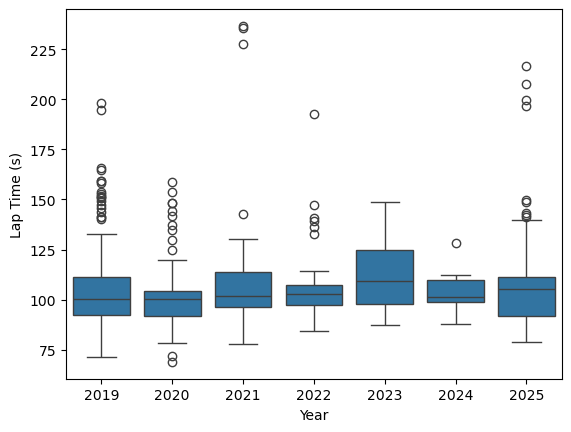

In [75]:
#check for outliers in laptime
sns.boxplot(x='Year', y='LapTime', data=laps_aggregated)
plt.ylabel("Lap Time (s)")
plt.show()

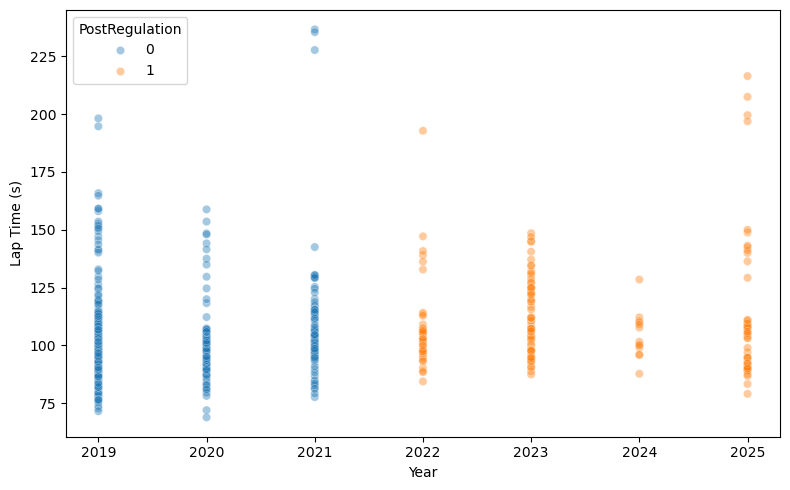

In [67]:
#plot distribution of laptime pre & post regulation
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=laps_aggregated,
    x='Year',
    y='LapTime',
    hue='PostRegulation',
    alpha=0.4
)

plt.xlabel("Year")
plt.ylabel("Lap Time (s)")
plt.tight_layout()
plt.show()

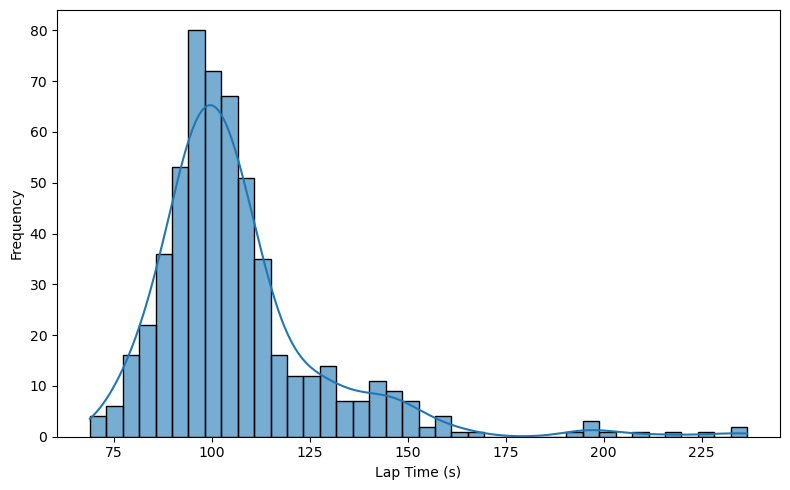

In [68]:
#plot distribution of lap time
plt.figure(figsize=(8,5))
sns.histplot(laps_aggregated['LapTime'], kde=True, color='tab:blue', alpha=0.6)
plt.xlabel("Lap Time (s)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

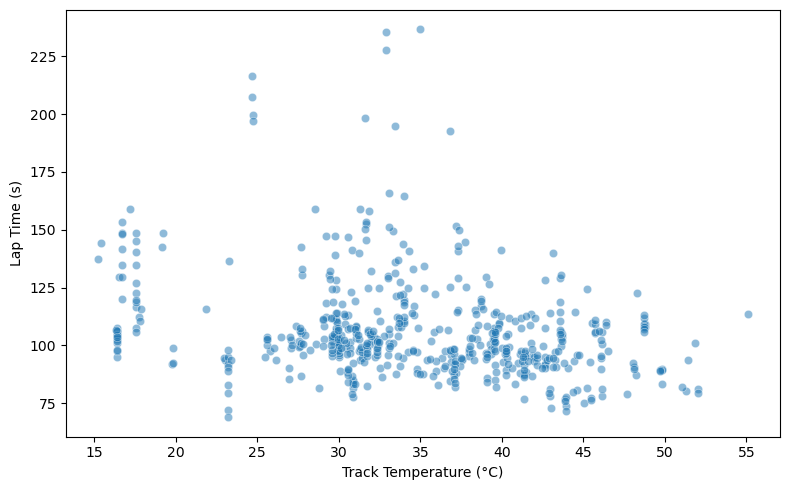

In [69]:
#compare laptime with tracktemp
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=laps_aggregated,
    x='TrackTemp',
    y='LapTime',
    alpha=0.5
)
plt.xlabel("Track Temperature (°C)")
plt.ylabel("Lap Time (s)")
plt.tight_layout()
plt.show()

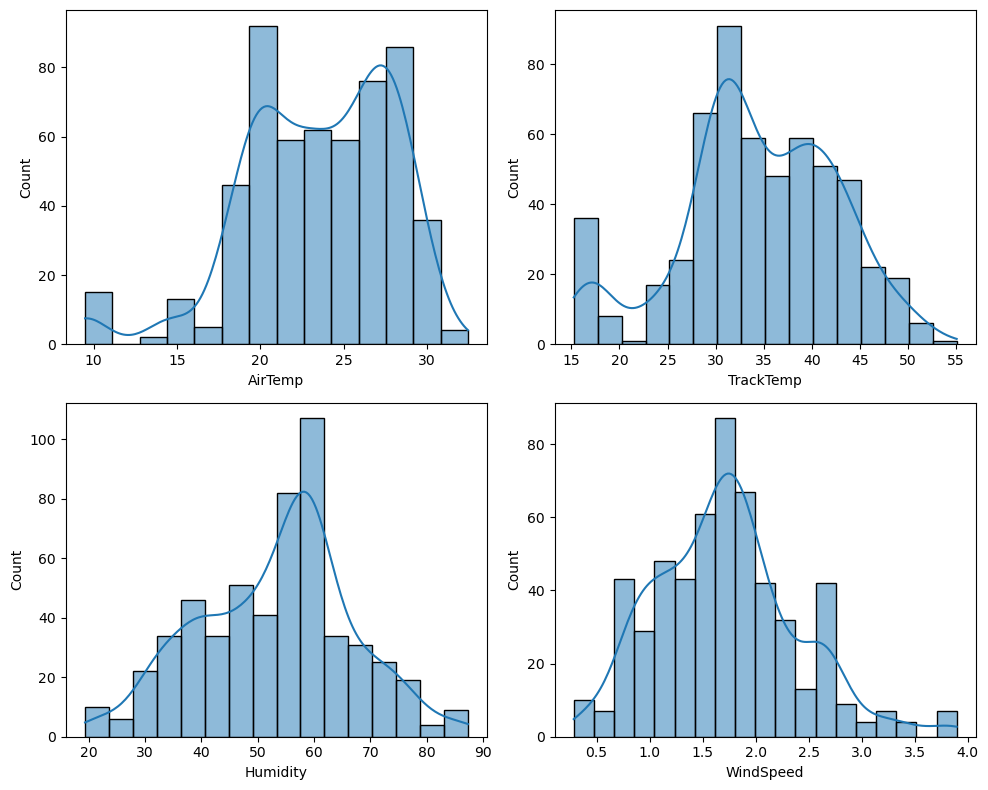

In [70]:
#weather variable distributions
fig, axes = plt.subplots(2, 2, figsize=(10,8))
sns.histplot(laps_aggregated, x='AirTemp', ax=axes[0,0], kde=True)
sns.histplot(laps_aggregated, x='TrackTemp', ax=axes[0,1], kde=True)
sns.histplot(laps_aggregated, x='Humidity', ax=axes[1,0], kde=True)
sns.histplot(laps_aggregated, x='WindSpeed', ax=axes[1,1], kde=True)
plt.tight_layout()
plt.show()

**Checking Multicollinearity and VIF**

In [71]:
#isolate numerical cols and print correlation between numerical vars
numerical_df = laps_aggregated.select_dtypes(include=['number'])
corr_matrix = numerical_df.corr()
print(corr_matrix)


                 DriverNumber  LapNumber     Stint   SpeedI1   SpeedI2  \
DriverNumber         1.000000   0.085636  0.017678 -0.033456  0.032506   
LapNumber            0.085636   1.000000  0.153117 -0.014860 -0.155030   
Stint                0.017678   0.153117  1.000000  0.004703 -0.074018   
SpeedI1             -0.033456  -0.014860  0.004703  1.000000  0.368282   
SpeedI2              0.032506  -0.155030 -0.074018  0.368282  1.000000   
SpeedFL              0.033678   0.176432  0.121149 -0.039645  0.226531   
SpeedST             -0.050328  -0.215395 -0.281323  0.231644  0.238194   
TyreLife             0.046598   0.563171 -0.239577 -0.109275 -0.123933   
TrackStatus          0.072750  -0.065453 -0.072288 -0.066195  0.091654   
Position            -0.171171  -0.066175  0.148556 -0.017584 -0.105811   
LapStartTimeSec      0.038745  -0.047399  0.149771  0.069436 -0.000225   
TimeSec              0.038766  -0.047459  0.149907  0.069313 -0.000235   
AirTemp              0.003505  -0.0419

**Mixed Effects Model (GLMM)**

                     Feature        VIF
0                  Intercept  17.628789
1     C(PostRegulation)[T.1]   1.130084
2   Compound[T.INTERMEDIATE]   1.658194
3         Compound[T.MEDIUM]   4.524758
4           Compound[T.SOFT]   4.678588
5        Compound[T.UNKNOWN]   1.093508
6            Compound[T.WET]   1.426190
7                      Stint   1.124260
8                    AirTemp   2.287657
9                  TrackTemp   2.978932
10                  Humidity   1.779243


/Users/seo/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seo/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/seo/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seo/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


Summary of Model
                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     LapTime   
No. Observations:       555         Method:                 REML      
No. Groups:             37          Scale:                  300.7323  
Min. group size:        1           Log-Likelihood:         -2353.0092
Max. group size:        26          Converged:              No        
Mean group size:        15.0                                          
----------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------------
Intercept                105.091    3.163 33.228 0.000  98.892 111.289
C(PostRegulation)[T.1]     5.414    1.815  2.984 0.003   1.858   8.970
Compound[T.INTERMEDIATE]  32.184    5.140  6.261 0.000  22.109  42.259
Compound[T.MEDIUM]        -3.155    3.164 -0.997 0.319  -9.357   3.047
Compou

/Users/seo/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/seo/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/seo/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 15.293718
  warnings.warn(msg, ConvergenceWarning)


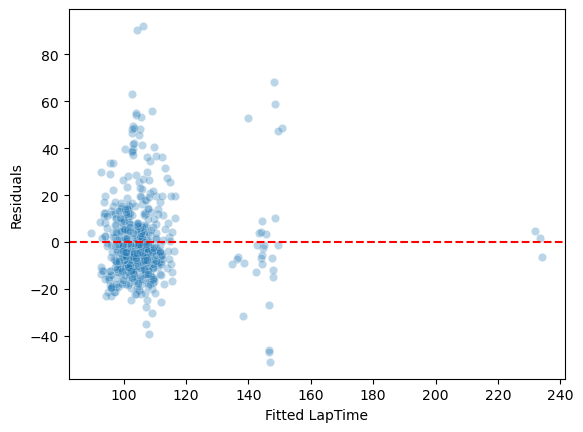

/var/folders/j5/byd_6b0s1xqcff_0967_q4c00000gn/T/ipykernel_62438/1984140548.py:52: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(x='PostRegulation', y='LapTime', data=df_model, ci='sd')


Text(0.5, 1.0, 'Estimated Effect of Regulation on Lap Time')

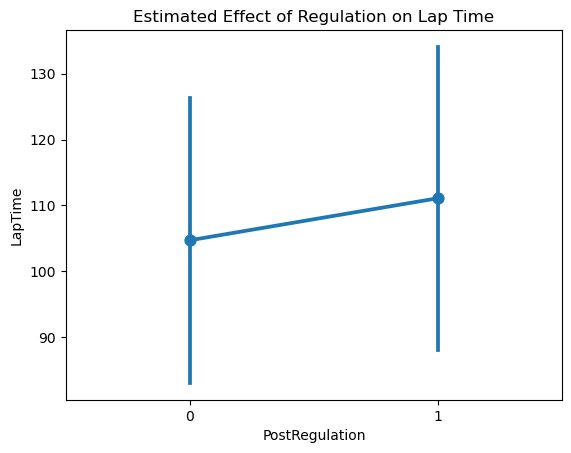

In [ ]:
#ensure categorical columns
laps_aggregated['Driver'] = laps_aggregated['Driver'].astype('category')
laps_aggregated['Team'] = laps_aggregated['Team'].astype('category')
laps_aggregated['RaceName'] = laps_aggregated['RaceName'].astype('category')
laps_aggregated['Compound'] = laps_aggregated['Compound'].astype('category')


scaler = StandardScaler()
cols_to_scale = ['Stint', 'AirTemp', 'TrackTemp', 'Humidity']

# Create a copy to avoid messing up original data
df_model = laps_aggregated.copy()
df_model[cols_to_scale] = scaler.fit_transform(df_model[cols_to_scale])

#linear mixed model
md = smf.mixedlm(
    "LapTime ~ C(PostRegulation) + Compound + Stint + AirTemp + TrackTemp + Humidity",
    data=df_model,
    groups=df_model["Driver"],   #random intercept for Driver
    re_formula="~1"
)

exog = md.exog
names = md.exog_names

#calculate VIF for each feature
vif_df = pd.DataFrame()
vif_df["Feature"] = names
vif_df["VIF"] = [variance_inflation_factor(exog, i) for i in range(exog.shape[1])]

print(vif_df)

mdf = md.fit()
print("Summary of Model")
print(mdf.summary())

#evaliuate RMSE
y_true = df_model['LapTime']
y_pred = mdf.fittedvalues
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
print(f"RMSE: {rmse:.3f} sec")

#visualize residuals and plot
residuals = y_true - y_pred
sns.scatterplot(x=y_pred, y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted LapTime")
plt.ylabel("Residuals")
plt.show()

#
sns.pointplot(x='PostRegulation', y='LapTime', data=laps_aggregated, ci='sd')
plt.title("Estimated Effect of Regulation on Lap Time")

**Random Forrest Classification**

In [30]:
#build numerical & target columns
target_column = 'PostRegulation'
categorical_features = ['Driver', 'Compound']
numerical_features = [
    'LapTime',
    'SpeedI1',
    'SpeedI2',
    'SpeedST',
    'SpeedFL',
    'AirTemp',
    'TrackTemp',
    'WindSpeed',
    'Humidity'
]

features_list = numerical_features + categorical_features
#check for missing data 
print(laps_aggregated[features_list + [target_column]].isnull().sum())
#define X/Y
X = laps_aggregated[features_list]
y = laps_aggregated[target_column]


#one-hot encoding
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print("Shape of X after encoding:", X_encoded.shape)
print("Columns in X_encoded:", X_encoded.columns.tolist())

#split data, 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

#iitialize classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
#fit model & run prediction
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

LapTime           0
SpeedI1           0
SpeedI2           0
SpeedST           0
SpeedFL           0
AirTemp           0
TrackTemp         0
WindSpeed         0
Humidity          0
Driver            0
Compound          0
PostRegulation    0
dtype: int64
Shape of X after encoding: (555, 50)
Columns in X_encoded: ['LapTime', 'SpeedI1', 'SpeedI2', 'SpeedST', 'SpeedFL', 'AirTemp', 'TrackTemp', 'WindSpeed', 'Humidity', 'Driver_ALB', 'Driver_ALO', 'Driver_ANT', 'Driver_BEA', 'Driver_BOR', 'Driver_BOT', 'Driver_COL', 'Driver_DEV', 'Driver_DOO', 'Driver_GAS', 'Driver_GIO', 'Driver_GRO', 'Driver_HAD', 'Driver_HAM', 'Driver_HUL', 'Driver_KVY', 'Driver_LAT', 'Driver_LAW', 'Driver_LEC', 'Driver_MAG', 'Driver_MAZ', 'Driver_MSC', 'Driver_NOR', 'Driver_OCO', 'Driver_PER', 'Driver_PIA', 'Driver_RAI', 'Driver_RIC', 'Driver_RUS', 'Driver_SAI', 'Driver_SAR', 'Driver_STR', 'Driver_TSU', 'Driver_VER', 'Driver_VET', 'Driver_ZHO', 'Compound_INTERMEDIATE', 'Compound_MEDIUM', 'Compound_SOFT', 'Compound_UNKNOWN'


Model Accuracy: 0.9550

Classification Report:
                     precision    recall  f1-score   support

 Pre-Regulation (0)       0.95      0.99      0.97        78
Post-Regulation (1)       0.97      0.88      0.92        33

           accuracy                           0.95       111
          macro avg       0.96      0.93      0.94       111
       weighted avg       0.96      0.95      0.95       111

Confusion Matrix:
[[77  1]
 [ 4 29]]

Confusion matrix plot saved as 'confusion_matrix.png'


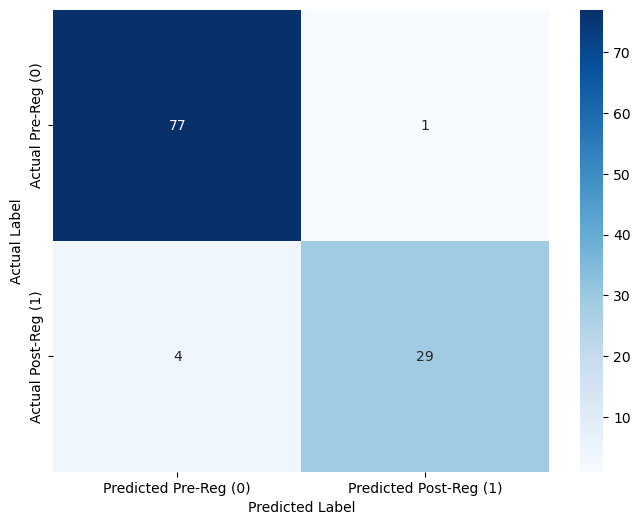

In [31]:
#model evaluation
#accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

#classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Pre-Regulation (0)', 'Post-Regulation (1)']))

#confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Pre-Reg (0)', 'Predicted Post-Reg (1)'],
            yticklabels=['Actual Pre-Reg (0)', 'Actual Post-Reg (1)'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
print("\nConfusion matrix plot saved as 'confusion_matrix.png'")

/var/folders/j5/byd_6b0s1xqcff_0967_q4c00000gn/T/ipykernel_62438/3958928695.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


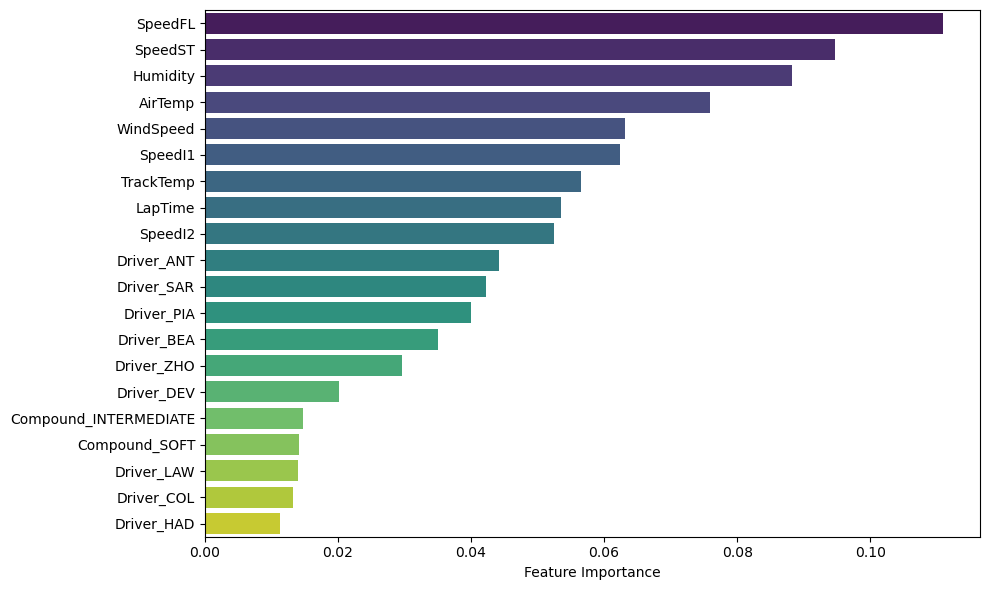

In [73]:
importances = rf_classifier.feature_importances_
feature_names = X_encoded.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

#plot features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature',
            data=feature_importance_df.head(20),
            palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('')
plt.tight_layout()
plt.show()